In [1]:
from sam.stress_addition_model import OLD_STANDARD, sam_prediction
from sam.stress_addition_model import (
    sam_prediction,
    get_sam_lcs,
    OLD_STANDARD
)
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.plotting import plot_sam_prediction
from sam.data_formats import load_datapoints
import os
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from tqdm import tqdm
from copy import deepcopy
from sam.data_formats import read_data

In [2]:
names = [
    ("liess_copper_2001", "Food_1% + UV"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_100"),
    
]

In [19]:

from sam.helpers import pad_c0

def pred_exp(path, exp, new = False, hormesis_index = None):
    
    settings = deepcopy(OLD_STANDARD)
    settings.cancel_system_stress = new
    
    
    data = read_data(f"data/{path}.xlsx")
    
    data.meta.hormesis_index = hormesis_index
    val = data.additional_stress[exp]
    print("untouched smallest value", val.concentration[0])
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=settings,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    title = None
    print("smallest value", stress_fit.inputs.concentration[0])
    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=title,
    )
    if new:
        fig.axes[-1].plot(main_fit.concentration_curve, main_fit.pred_system_stress, label = "system")
        fig.axes[-1].legend()
    plt.show()

untouched smallest value 0.0
smallest value 1.5


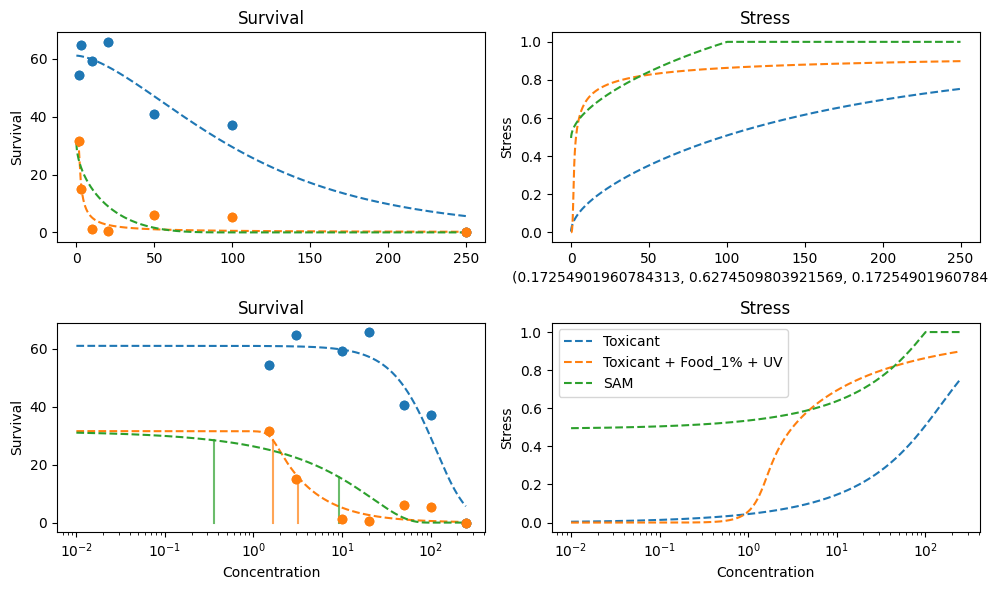

untouched smallest value 0.0
could not find hormesis index, detecting it
smallest value 1.5


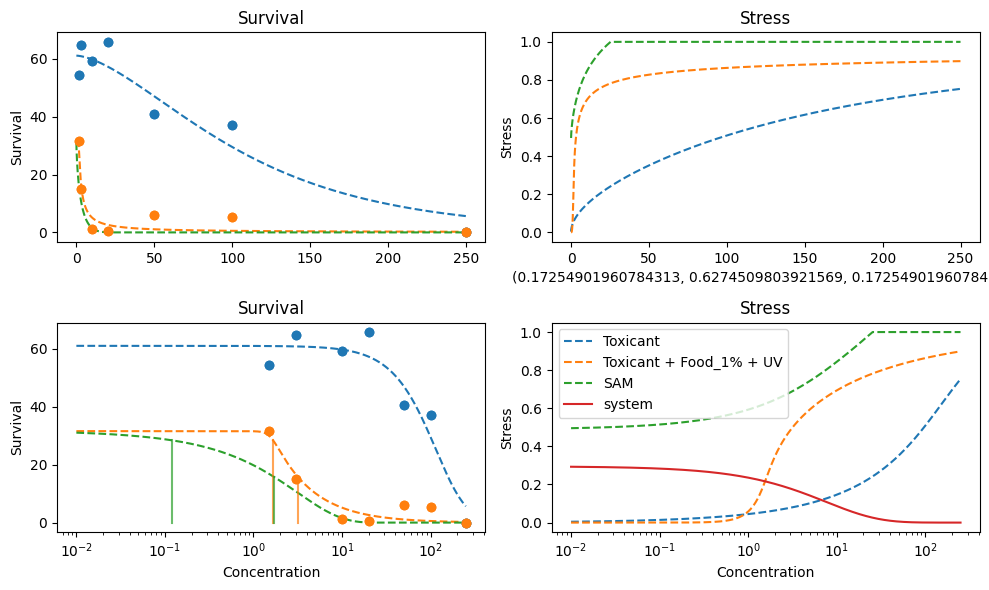

In [20]:
pred_exp(*names[0], new = False, hormesis_index= None)
pred_exp(*names[0], new = True, hormesis_index= None)

untouched smallest value 0.0
smallest value 5e-05


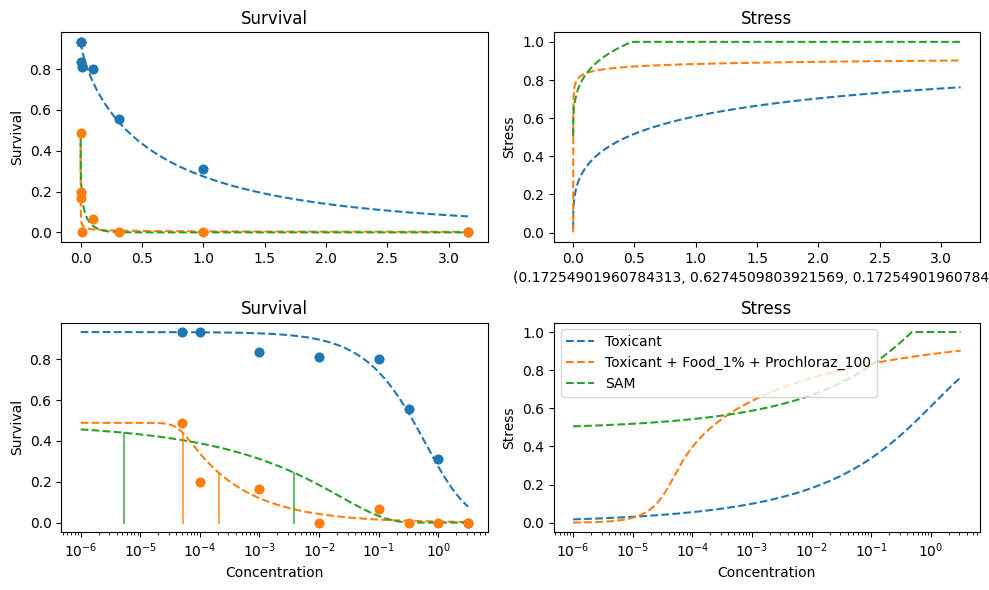

untouched smallest value 0.0


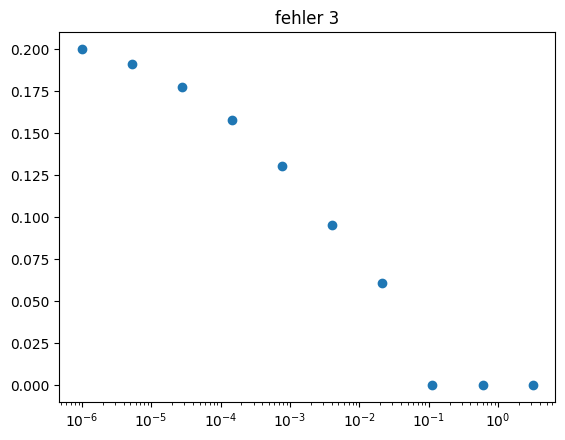

Weibull 3-param fit failed, defaulting to linear regression
smallest value 5e-05


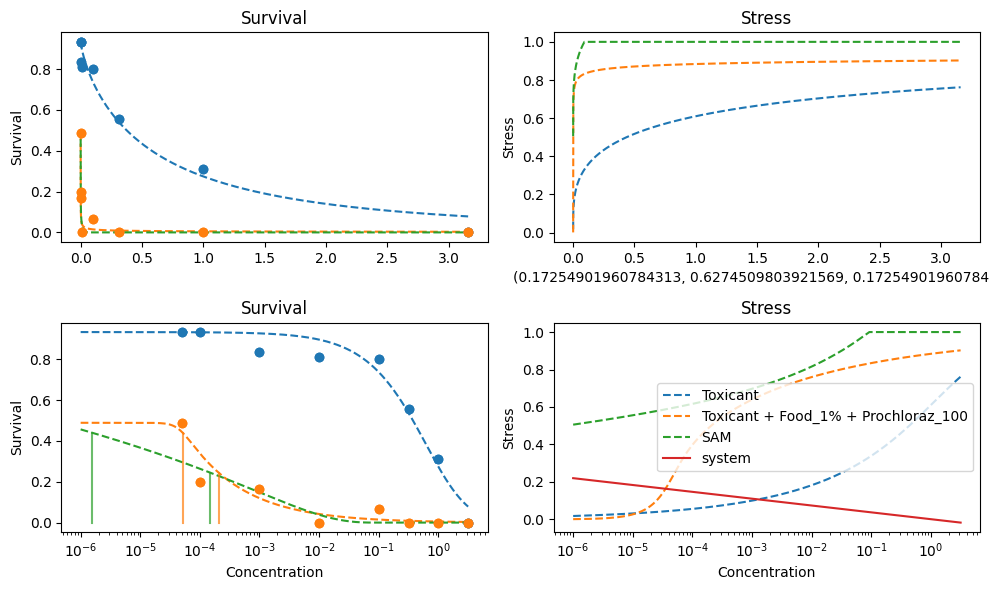

In [21]:
pred_exp(*names[1], new = False, hormesis_index= None)
pred_exp(*names[1], new = True, hormesis_index= 4)